# Mall Customer

In [1]:
import os
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans



warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [2]:
data = pd.read_csv('Mall_Customers.csv')

In [3]:
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
data.drop(columns = ['CustomerID'], inplace = True)

In [6]:
data['Gender'] = data['Gender'].replace({'Male': 1, 'Female': 0})

In [7]:
data.describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.440000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,0.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


## Agglomerative Clustering

In [8]:
AC = AgglomerativeClustering(n_clusters = 5)

In [9]:
data.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [10]:
x = data[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

AC.fit(x)

AgglomerativeClustering(n_clusters=5)

In [11]:
y_predict = AC.fit_predict(x)

In [12]:
clust_df = pd.DataFrame(y_predict)

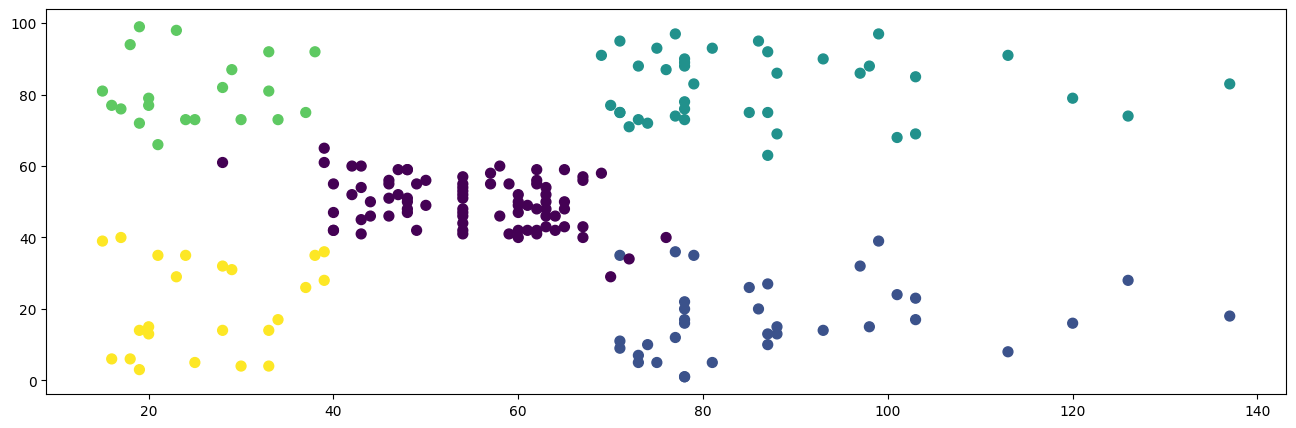

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16, 5))
ax = fig.add_subplot(1,1,1)
scatter = ax.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], s = 50, c = clust_df[0])

In [14]:
clust_df.value_counts()

0    83
2    39
1    35
4    23
3    20
Name: count, dtype: int64

In [15]:
x

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
195,0,35,120,79
196,0,45,126,28
197,1,32,126,74
198,1,32,137,18


In [16]:
# Define features
features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

# Run KMeans (example with 5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42)
x["Cluster"] = kmeans.fit_predict(x[features])


## Marketing Segmentation

In [17]:
# Group by cluster to profile customers
features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

cluster_profile = x.groupby("Cluster")[features].mean().round(1)
cluster_profile["Count"] = x["Cluster"].value_counts()
cluster_profile["% of Customers"] = round((cluster_profile["Count"]/len(x))*100, 2)

print(cluster_profile)

          Age  Annual Income (k$)  Spending Score (1-100)  Count  \
Cluster                                                            
0        46.2                47.7                    41.8     89   
1        32.5               108.2                    82.7     11   
2        24.7                29.6                    73.7     29   
3        40.4                87.0                    18.6     38   
4        31.8                76.1                    77.8     33   

         % of Customers  
Cluster                  
0                  44.5  
1                   5.5  
2                  14.5  
3                  19.0  
4                  16.5  


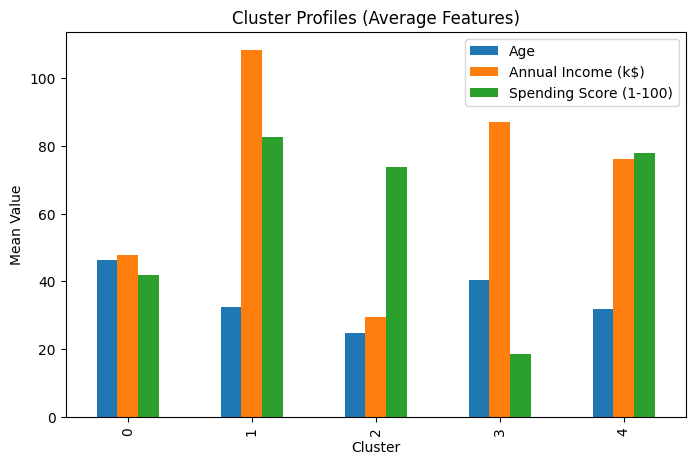

In [18]:
# Plot profiles
cluster_profile[features].plot(kind="bar", figsize=(8,5))
plt.title("Cluster Profiles (Average Features)")
plt.ylabel("Mean Value")
plt.show()

## Customer Lifetime Value (CLV) Proxy

In [19]:
# CLV Proxy = Income * Spending Score
x["CLV_Proxy"] = x["Annual Income (k$)"] * x["Spending Score (1-100)"]

# Average CLV per cluster
clv_profile = x.groupby("Cluster")["CLV_Proxy"].mean().round(2)
print(clv_profile)

Cluster
0    2145.75
1    8920.64
2    2120.24
3    1634.97
4    5958.91
Name: CLV_Proxy, dtype: float64


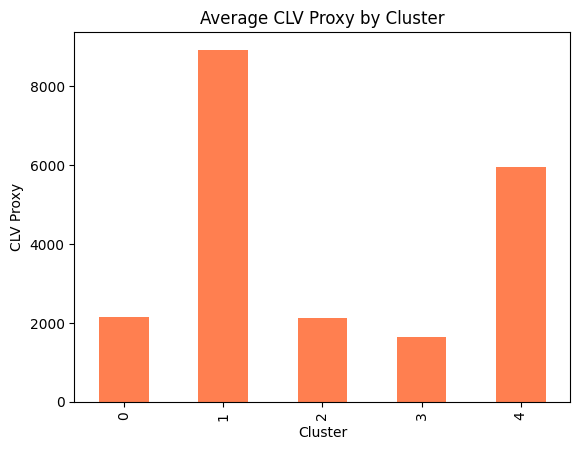

In [20]:
# Visualize
clv_profile.plot(kind="bar", color="coral")
plt.title("Average CLV Proxy by Cluster")
plt.ylabel("CLV Proxy")
plt.show()

## Churn Prediction (Simulated)

In [21]:
# Define churn (label: 1=churn risk, 0=active)
x["ChurnRisk"] = (x["Spending Score (1-100)"] < 40).astype(int)

X = x[["Age", "Annual Income (k$)"]]
y = x["ChurnRisk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        40
           1       0.75      0.60      0.67        20

    accuracy                           0.80        60
   macro avg       0.78      0.75      0.76        60
weighted avg       0.80      0.80      0.79        60



## Revenue Optimization

In [24]:
# Current revenue proxy
x["Revenue"] = x["Annual Income (k$)"] * (x["Spending Score (1-100)"]/100)

current_revenue = x["Revenue"].sum()

# What-if: boost spending by 10% for cluster 1
boosted = x.copy()
boosted.loc[boosted["Cluster"]==1, "Spending Score (1-100)"] *= 1.1

boosted["Revenue"] = boosted["Annual Income (k$)"] * (boosted["Spending Score (1-100)"]/100)
new_revenue = boosted["Revenue"].sum()

print("Current Revenue:", round(current_revenue,2))
print("New Revenue (with 10% boost on Cluster 1):", round(new_revenue,2))
print("Revenue Gain:", round(new_revenue - current_revenue,2))


Current Revenue: 6093.59
New Revenue (with 10% boost on Cluster 1): 6191.72
Revenue Gain: 98.13


## Customer Journey Analysis (Cohorts)

In [25]:
# Create Age Groups
x["AgeGroup"] = pd.cut(x["Age"], bins=[0,20,30,40,50,60,100],
                        labels=["<20","20-30","30-40","40-50","50-60","60+"])

# Average spending per cohort
cohort_spending = x.groupby("AgeGroup")["Spending Score (1-100)"].mean().round(2)

print(cohort_spending)


AgeGroup
<20      44.65
20-30    67.22
30-40    57.50
40-50    34.39
50-60    32.52
60+      44.18
Name: Spending Score (1-100), dtype: float64


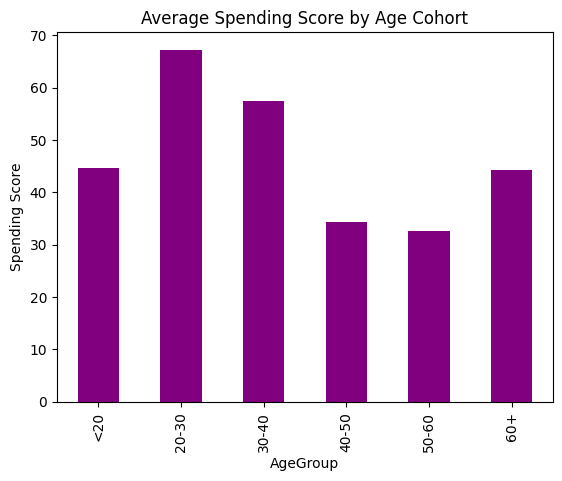

In [26]:
cohort_spending.plot(kind="bar", color="purple")
plt.title("Average Spending Score by Age Cohort")
plt.ylabel("Spending Score")
plt.show()

## Chi-Square Test

In [27]:
# Create a contingency table
contingency_table = pd.crosstab(x["Gender"], x["Cluster"])
print("Contingency Table:\n", contingency_table)

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test Results")
print("Chi2 Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("p-value:", p)

# Interpretation
if p < 0.05:
    print("\n✅ Significant relationship: Gender distribution differs across clusters.")
else:
    print("\n❌ No significant relationship: Gender distribution is similar across clusters.")


Contingency Table:
 Cluster   0  1   2   3   4
Gender                    
0        55  6  15  18  18
1        34  5  14  20  15

Chi-Square Test Results
Chi2 Statistic: 2.6161104504130175
Degrees of Freedom: 4
p-value: 0.6239718966077779

❌ No significant relationship: Gender distribution is similar across clusters.
